## Project Context and Goal
Explore rental affordability as part of the **Good Deal Finder** project by identifying **ZIP-level patterns** of rent-to-income affordability and forecast short-term changes using **Zillow Observed Rent Index (ZORI)** and **ACS income data**.

*Our innovation:*

National and metro-level indicators such as the **Freddie Mac Rental Affordability Curve (2023)** and studies by **Edmiston (2023)** and **Molloy et al. (2022)** show broad affordability trends but warn that they **mask important local variation**.  
To address this, we model rents at the **ZIP level**, while still using **metro-level seasonality and volatility** as priors where ZIP data are sparse.

### From Zillow's website (https://www.zillow.com/research/data/)

* Zillow Observed Rent Index (ZORI): A smoothed measure of the typical observed market rate rent across a given region. ZORI is a repeat-rent index that is weighted to the rental housing stock to ensure representativeness across the entire market, not just those homes currently listed for-rent. The index is dollar-denominated by computing the mean of listed rents that fall into the 35th to 65th percentile range for all homes and apartments in a given region, which is weighted to reflect the rental housing stock.

ZORI is created for three different categories: All homes, Single Family Residences, and Multi-Family Residences. For more detailed information, you can refer to the ZORI methodology (https://www.zillow.com/research/methodology-zori-repeat-rent-27092/).

* Zillow Observed Renter Demand Index (ZORDI): A measure of the typical observed rental market engagement across a region. ZORDI tracks engagement on Zillow’s rental listings to proxy changes in rental demand. The metric is smoothed to remove volatility.

ZORDI is created for different categories including All homes, Single Family Residences, Condo and Multi-Family Residences at national and MSA levels.

## Why This Is Hard
Seasonality and volatility are well established at the metro level (**Waller / Titman & Zhu**).  
However, directly applying metro-wide seasonal patterns to all ZIP codes assumes neighborhoods move in lockstep, which the literature shows is false.  
For example, **Edmiston** found that affordability "varies widely across MSAs," and **Samarin** show local economic specialization drives different rent-burden intensities even within the same city.

### Our Approach (Maybe)
1. **Extract Metro Level Data from ZORDI**  
For each metro area, decompose ZORDI into its long-term trend and month-specific deviations. These deviations represent the percentage change from trend—our measure of metro-level seasonality and volatility.

2. **Apply Metro Deviations to ZIP-Level ZORI**  
We transfer these metro deviations to ZIP-level ZORI as multipliers. (could potentially add a scaling factor to account for ZIP-level particularities - see below)

3. **Resulting Output**
   - **ZORI_adjusted:** A somewhat unsmoothed ZIP-level rent index that reflects the metro-level behavior.
   - **Volatility:** Indicators for periods of elevated rent swings.
   - **Seasonality:** Monthly rent patterns derived from ZORDI’s metro data.

### TODO: Forecasting and Affordability
Once we validate the adjusted data, we can:
- **Forecast rent** using the adjusted ZIP-level time series (ARIMA, ETS, or ____ models).
- **Compute rent-to-income ratios** by combining forecasted rents with ACS income data, enabling ZIP-level affordability maps and projections (6mo, 1y?).

This  allows us to first align the **temporal part** (ZORDI to ZORI), then explore the **economic implications** (rent forecasts and affordability).

## Data Preparation
ZORI provides repeat-rent indices by ZIP and metro.  
ACS income data (2022) are merged and forward-filled monthly to align with rent observations.  
All rents could be log-transformed for stability, and dates normalized to month start (MS) frequency.

So far:
- Merge ZORI rent data with ACS income data. (2022 as sample)
- Align geographic identifiers (ZIPs and metros).
- Clean and structure monthly time series suitable for modeling.

The notebook does *not yet* include a proper EDA with descriptive checks (missingness, trends, distributions), the forecasting or volatility modeling steps.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests

#### Load ZORI Data and Create ATL sample

In [2]:
zori_sm = pd.read_csv('Zip_zori_uc_sfrcondomfr_sm_month.csv')

zori_sm

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2015-01-31,...,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,1477.375375,...,1872.966783,1871.953733,1870.392243,1877.681128,1881.057107,1883.874370,1880.754424,1887.499216,1893.311781,1891.123162
1,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,1250.594484,...,1823.359969,1831.336598,1846.458725,1862.430930,1865.523469,1859.787190,1852.214376,1847.999990,1838.403610,1829.945544
2,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,1128.386480,...,1645.964463,1633.944263,1651.396440,1654.600721,1658.423420,1632.439580,1629.774745,1626.105730,1633.660291,1634.061782
3,93144,6,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,NaN,...,1425.434897,1452.760752,1468.584177,1463.016450,1433.878989,1431.898435,1443.356783,1465.914015,1465.093537,1463.357895
4,62093,7,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,NaN,...,3022.910560,3065.408046,3102.631357,3156.463428,3156.027599,3220.856950,3269.026210,3335.566372,3315.108613,3300.138507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7844,418163,30158,89158,zip,NV,NV,Las Vegas,"Las Vegas-Henderson-Paradise, NV",Clark County,NaN,...,NaN,NaN,NaN,NaN,NaN,3174.262295,3209.881854,3367.593639,NaN,3383.333333
7845,70410,30172,29333,zip,SC,SC,Spartanburg,"Spartanburg, SC",Spartanburg County,NaN,...,NaN,NaN,NaN,NaN,1384.924336,1440.342946,1446.580632,1469.915758,1433.865130,1441.444444
7846,61618,30490,10004,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,NaN,...,4772.813410,4805.478462,4871.754742,4925.958756,5015.744651,5051.345227,5130.385523,5118.502295,5166.909864,5207.319444
7847,91179,30490,76005,zip,TX,TX,Arlington,"Dallas-Fort Worth-Arlington, TX",Tarrant County,NaN,...,2159.614724,2171.647073,2156.712118,2165.223669,2175.485017,2218.191497,2246.893678,2275.001565,2246.093707,2216.444444


In [3]:
value_vars = [col for col in zori_sm.columns if col[:4].isdigit()]

zori_sm_long = zori_sm.melt(
    id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName'],
    value_vars = value_vars,
    var_name='Date',
    value_name='Rent'
)

zori_sm_long['Date'] = pd.to_datetime(zori_sm_long['Date'])

zori_sm_long

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Rent
0,91982,1,77494,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,2015-01-31,1477.375375
1,91940,3,77449,zip,TX,TX,Katy,"Houston-The Woodlands-Sugar Land, TX",Harris County,2015-01-31,1250.594484
2,91733,5,77084,zip,TX,TX,Houston,"Houston-The Woodlands-Sugar Land, TX",Harris County,2015-01-31,1128.386480
3,93144,6,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,2015-01-31,NaN
4,62093,7,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2015-01-31,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1012516,418163,30158,89158,zip,NV,NV,Las Vegas,"Las Vegas-Henderson-Paradise, NV",Clark County,2025-09-30,3383.333333
1012517,70410,30172,29333,zip,SC,SC,Spartanburg,"Spartanburg, SC",Spartanburg County,2025-09-30,1441.444444
1012518,61618,30490,10004,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,2025-09-30,5207.319444
1012519,91179,30490,76005,zip,TX,TX,Arlington,"Dallas-Fort Worth-Arlington, TX",Tarrant County,2025-09-30,2216.444444


In [4]:
# Sample the Atlanta area
atl = zori_sm_long[zori_sm_long['Metro'].str.contains('Atlanta', na=False)]

atl

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Rent
17,70829,21,30044,zip,GA,GA,Lawrenceville,"Atlanta-Sandy Springs-Alpharetta, GA",Gwinnett County,2015-01-31,998.857681
47,70828,53,30043,zip,GA,GA,Lawrenceville,"Atlanta-Sandy Springs-Alpharetta, GA",Gwinnett County,2015-01-31,1077.081539
85,70810,94,30024,zip,GA,GA,Suwanee,"Atlanta-Sandy Springs-Alpharetta, GA",Gwinnett County,2015-01-31,1187.986475
122,71067,132,30349,zip,GA,GA,NaN,"Atlanta-Sandy Springs-Alpharetta, GA",Fulton County,2015-01-31,926.443540
148,70825,160,30040,zip,GA,GA,Cumming,"Atlanta-Sandy Springs-Alpharetta, GA",Forsyth County,2015-01-31,1364.083726
...,...,...,...,...,...,...,...,...,...,...,...
1012057,71045,10577,30326,zip,GA,GA,Atlanta,"Atlanta-Sandy Springs-Alpharetta, GA",Fulton County,2025-09-30,2000.724621
1012245,71023,11821,30303,zip,GA,GA,Atlanta,"Atlanta-Sandy Springs-Alpharetta, GA",Fulton County,2025-09-30,2140.166667
1012370,71064,13560,30346,zip,GA,GA,Dunwoody,"Atlanta-Sandy Springs-Alpharetta, GA",Dekalb County,2025-09-30,1851.924784
1012411,70858,14585,30079,zip,GA,GA,Scottdale,"Atlanta-Sandy Springs-Alpharetta, GA",Dekalb County,2025-09-30,2000.000000


## Exploratory Data Analysis

Before modeling, this notebook should examine things like:
- Rent growth trends by metro and ZIP.
- Distribution of rent-to-income ratios.
- Identification of data gaps and irregular ZIPs.
- Early indicators of volatility (rolling rent change).

These plots and tables could help us see which metros and ZIPs behave consistently enough to be modeled later.

#### Confirm that smoothed data by ZIP code insufficient for seasonality/volatility modeling

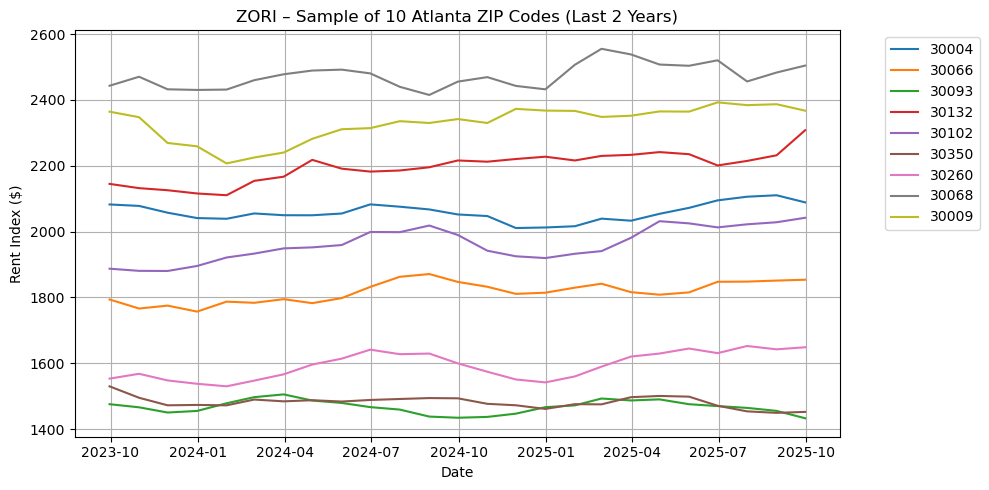

In [5]:
# 10 samples zips, last 2 years
sample_zips = atl['RegionName'].dropna().sample(10, random_state=42)
atl_sample = atl[atl['RegionName'].isin(sample_zips)]
cutoff = atl_sample['Date'].max() - pd.DateOffset(years=2)
atl_recent = atl_sample[atl_sample['Date'] >= cutoff]

plt.figure(figsize=(10,5))
for zip_code in atl_recent['RegionName'].unique():
    subset = atl_recent[atl_recent['RegionName'] == zip_code]
    plt.plot(subset['Date'], subset['Rent'], label=str(zip_code))

plt.title("ZORI – Sample of 10 Atlanta ZIP Codes (Last 2 Years)")
plt.xlabel("Date")
plt.ylabel("Rent Index ($)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

#### Load ZORDI Data and create ATL sample

In [6]:
zordi_raw = pd.read_csv('Metro_zordi_uc_sfrcondomfr_month.csv')

zordi_raw

,RegionID,SizeRank,RegionName,RegionType,StateName,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,...,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30
0,102001,0,United States,country,NaN,100.0,102.0,95.0,85.0,74.0,...,41.0,31.0,19.0,NaN,NaN,NaN,NaN,NaN,42.0,33.0
1,394913,1,"New York, NY",msa,NY,53.0,51.0,53.0,58.0,58.0,...,80.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0
2,753899,2,"Los Angeles, CA",msa,CA,134.0,132.0,116.0,96.0,81.0,...,55.0,42.0,24.0,NaN,NaN,NaN,NaN,NaN,53.0,43.0
3,394463,3,"Chicago, IL",msa,IL,97.0,91.0,72.0,50.0,39.0,...,81.0,63.0,40.0,18.0,15.0,NaN,NaN,NaN,86.0,65.0
4,394514,4,"Dallas, TX",msa,TX,108.0,104.0,91.0,80.0,72.0,...,22.0,17.0,11.0,5.0,4.0,NaN,NaN,NaN,21.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,394342,929,"Atchison, KS",msa,KS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12.0,-6.0,6.0,15.0,18.0,13.0
891,753880,930,"Fairfield, IA",msa,IA,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,5.0,2.0,1.0,-1.0,5.0,9.0,11.0,8.0
892,395186,932,"Vermillion, SD",msa,SD,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0
893,394743,936,"Ketchikan, AK",msa,AK,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0


In [7]:
value_vars = [col for col in zordi_raw.columns if col[:4].isdigit()]

zordi_raw_long = zordi_raw.melt(
    id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'],
    value_vars = value_vars,
    var_name='Date',
    value_name='Rent'
)

zordi_raw_long['Date'] = pd.to_datetime(zordi_raw_long['Date'])
zordi_raw_long = zordi_raw_long.dropna(subset=['Rent']) # TODO: is this a good idea? Also need to deal with any gaps

zordi_raw_long

,RegionID,SizeRank,RegionName,RegionType,StateName,Date,Rent
0,102001,0,United States,country,NaN,2020-06-30,100.0
1,394913,1,"New York, NY",msa,NY,2020-06-30,53.0
2,753899,2,"Los Angeles, CA",msa,CA,2020-06-30,134.0
3,394463,3,"Chicago, IL",msa,IL,2020-06-30,97.0
4,394514,4,"Dallas, TX",msa,TX,2020-06-30,108.0
...,...,...,...,...,...,...,...
57275,394342,929,"Atchison, KS",msa,KS,2025-09-30,13.0
57276,753880,930,"Fairfield, IA",msa,IA,2025-09-30,8.0
57277,395186,932,"Vermillion, SD",msa,SD,2025-09-30,33.0
57278,394743,936,"Ketchikan, AK",msa,AK,2025-09-30,53.0


In [8]:
atl_zordi = zordi_raw_long[zordi_raw_long['RegionName'].str.contains('Atlanta', na=False)]

atl_zordi

,RegionID,SizeRank,RegionName,RegionType,StateName,Date,Rent
9,394347,9,"Atlanta, GA",msa,GA,2020-06-30,212.0
904,394347,9,"Atlanta, GA",msa,GA,2020-07-31,228.0
1799,394347,9,"Atlanta, GA",msa,GA,2020-08-31,227.0
2694,394347,9,"Atlanta, GA",msa,GA,2020-09-30,216.0
3589,394347,9,"Atlanta, GA",msa,GA,2020-10-31,200.0
...,...,...,...,...,...,...,...
50129,394347,9,"Atlanta, GA",msa,GA,2025-02-28,16.0
51024,394347,9,"Atlanta, GA",msa,GA,2025-03-31,7.0
51919,394347,9,"Atlanta, GA",msa,GA,2025-04-30,6.0
55499,394347,9,"Atlanta, GA",msa,GA,2025-08-31,35.0


#### Confirm ZORDI (raw) data adequate for volatility and seasonality modeling

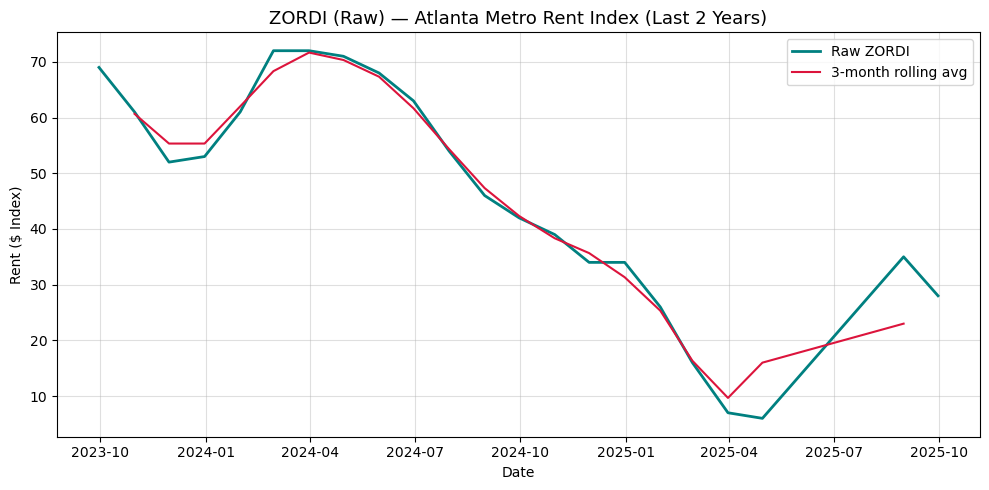

In [9]:
# filter to last 2 years
end_date = atl_zordi['Date'].max()
start_date = end_date - pd.DateOffset(years=2)
atl_zordi_recent = atl_zordi[atl_zordi['Date'] >= start_date].copy()
atl_zordi_recent = atl_zordi_recent.sort_values('Date')
atl_zordi_recent['Rolling'] = atl_zordi_recent['Rent'].rolling(window=3, center=True).mean()


plt.figure(figsize=(10,5))
plt.plot(atl_zordi_recent['Date'], atl_zordi_recent['Rent'],
         color='teal', linewidth=2, label='Raw ZORDI')
plt.plot(atl_zordi_recent['Date'], atl_zordi_recent['Rolling'],
         color='crimson', label='3-month rolling avg')
plt.title("ZORDI (Raw) — Atlanta Metro Rent Index (Last 2 Years)", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Rent ($ Index)")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

## Metro-Level Seasonality / Volatility -> Zip-Level (Example: Atlanta, General)

This is an example of how it could be applied in a general way.

### Limitations and ZIP-Level Particularities

By applying metro-level ZORDI deviations to ZIP-level ZORI, we assume that each ZIP responds to metro-wide shocks in the same proportion.

In reality, ZIPs differ in their rent elasticity and volatility:
- Urban ZIPs often respond faster.
- Suburban ZIPs may adjust more slowly.
- Student areas have their own seasonality.

Because Zillow publishes ZORDI only at the **metro level**, we cannot directly observe these variations. To remain transparent, our current adjustment treats each ZIP as equally exposed to its metro’s seasonal and volatility pattern.

Future refinements could include indicators like (and I am still thinking through these):
- Historical ZORI variance (proxy for volatility sensitivity)
- Rent level relative to metro median (proxy for elasticity)
- Housing composition or distance from the metro core (if available)

In short: we reintroduce metro-level volatility into ZIP-level rents, but we acknowledge that we cannot yet capture **how strongly each ZIP should respond.**

In [10]:
# Compute month from date
atl_zordi.loc[:, 'month'] = atl_zordi['Date'].dt.month

# Compute month-over-month percent change in rent
atl_zordi = atl_zordi.sort_values('Date')
atl_zordi['pct_change'] = atl_zordi['Rent'].pct_change()

# Derive average percent change per calendar month
season_pattern = atl_zordi.groupby('month')['pct_change'].mean()

# Convert this monthly percent change pattern into a cumulative multiplier over the year
#  so January = 1.00 baseline, each month offset reflects its typical deviation)
season_pattern = 1 + season_pattern.cumsum()
season_pattern = season_pattern / season_pattern.mean()  # normalize around 1

# clip extremes if any months swing too far
season_pattern = season_pattern.clip(lower=0.9, upper=1.1)

# Volatility pattern

# compute std of percent change per month
#vol_pattern = atl_zordi.groupby('month')['pct_change'].std()
vol_pattern = atl_zordi.groupby('month')['pct_change'].apply(lambda x: x.abs().mean())

# normalize around mean
vol_pattern = vol_pattern / vol_pattern.mean()

# scale down amplitude
vol_pattern = 1 + (vol_pattern - 1) * 0.2
#vol_pattern = vol_pattern.clip(lower=0.9, upper=1.1)

/var/folders/v6/rt7shrqx5sldb75bkwymnhlw0000gp/T/ipykernel_44860/1811418768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atl_zordi.loc[:, 'month'] = atl_zordi['Date'].dt.month


In [11]:
# Add month and merge in seasonality and volatility multipliers
atl = atl.drop(columns=['SeasonMult', 'VolMult'], errors='ignore')
atl = atl.assign(month=atl['Date'].dt.month.astype(int))

season_df = (
    season_pattern.rename('SeasonMult')
    .reset_index(drop=True)
    .to_frame()
    .assign(month=lambda df: df.index + 1)  # months 1–12
)

vol_df = (
    vol_pattern.rename('VolMult')
    .reset_index(drop=True)
    .to_frame()
    .assign(month=lambda df: df.index + 1)
)

atl = (
    atl.merge(season_df, on='month', how='left')
       .merge(vol_df,    on='month', how='left')
)

# Dampen multipliers and fill
alpha = 0.6  # 0.4–0.7 looks good
atl['SeasonMult'] = (1 + (atl['SeasonMult'] - 1) * alpha).fillna(1.0)
#atl['VolMult']    = atl['VolMult'].clip(0.95, 1.05).fillna(1.0)

# Apply metro-level seasonality to zips
atl['AdjRent'] = atl['Rent'] * atl['SeasonMult']

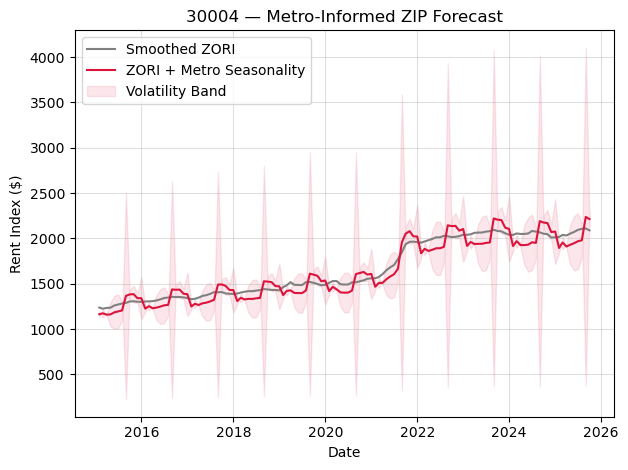

In [12]:
zip_id = atl['RegionName'].sample(1, random_state=42).iloc[0]
sub = atl[atl['RegionName'] == zip_id].sort_values('Date').copy()

delta = (sub['VolMult'] - 1.0)   
lower = sub['AdjRent'] * (1 - delta)
upper = sub['AdjRent'] * (1 + delta)

plt.plot(sub['Date'], sub['Rent'],     color='gray',   label='Smoothed ZORI')
plt.plot(sub['Date'], sub['AdjRent'],  color='crimson',label='ZORI + Metro Seasonality')
plt.fill_between(sub['Date'], lower, upper, color='crimson', alpha=0.10, label='Volatility Band')
plt.title(f"{zip_id} — Metro-Informed ZIP Forecast")
plt.xlabel("Date"); plt.ylabel("Rent Index ($)")
plt.legend(); plt.grid(True, alpha=0.4)
plt.tight_layout(); plt.show()

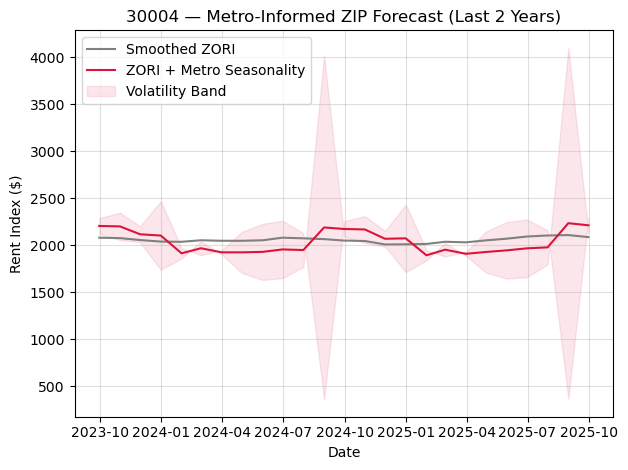

In [13]:
# filter to last 2 years based on max date in this ZIP's series
end_date = sub['Date'].max()
start_date = end_date - pd.DateOffset(years=2)
sub2 = sub[(sub['Date'] >= start_date)]

delta = (sub2['VolMult'] - 1.0)        
lower = sub2['AdjRent'] * (1 - delta)
upper = sub2['AdjRent'] * (1 + delta)

plt.plot(sub2['Date'], sub2['Rent'],     color='gray',   label='Smoothed ZORI')
plt.plot(sub2['Date'], sub2['AdjRent'],  color='crimson',label='ZORI + Metro Seasonality')
plt.fill_between(sub2['Date'], lower, upper, color='crimson', alpha=0.10, label='Volatility Band')
plt.title(f"{zip_id} — Metro-Informed ZIP Forecast (Last 2 Years)")
plt.xlabel("Date"); plt.ylabel("Rent Index ($)")
plt.legend(); plt.grid(True, alpha=0.4)
plt.tight_layout(); plt.show()

### TODO: Need to Continue - Started to Merge ACS Data and Try a Forecast
Forecast the rent-to-income ratio at ZIP or metro-level using ACS dataset. Below is a sample, year 2022 pulled.

In [14]:
# Get 2022 ACS 5-Year data for all ZIP codes
url = "https://api.census.gov/data/2022/acs/acs5"
params = {
    "get": "NAME,B19013_001E",
    "for": "zip code tabulation area:*"
}

r = requests.get(url, params=params)
data = r.json()

acs = pd.DataFrame(data[1:], columns=data[0])
acs.rename(columns={
    "NAME": "RegionName",
    "B19013_001E": "MedianIncome",
    "zip code tabulation area": "ZIP"
}, inplace=True)

acs["MedianIncome"] = pd.to_numeric(acs["MedianIncome"], errors="coerce")
acs["ZIP"] = acs["ZIP"].astype(str)
acs.head()

,RegionName,MedianIncome,ZIP
0,ZCTA5 00601,17526,00601
1,ZCTA5 00602,20260,00602
2,ZCTA5 00603,17703,00603
3,ZCTA5 00606,19603,00606
4,ZCTA5 00610,22796,00610


In [25]:
# ACS is yearly - interpolate monthly (TODO: is this how we want to do this?)

acs.loc[:, 'Year'] = 2022
acs['Date'] = pd.to_datetime('2022-01-01')
acs['ZIP'] = acs['ZIP'].astype(str).str.zfill(5)

# Rename to keep consistent naming
acs.rename(columns={'MedianIncome': 'MonthlyIncome'}, inplace=True)

# Create a full monthly timeline for your ZORI data
span = pd.date_range(atl['Date'].min().to_period('M').to_timestamp('MS'),
                     atl['Date'].max().to_period('M').to_timestamp('MS'),
                     freq='MS')

# Expand each ZIP to all months and forward-fill the 2022 income value
acs_monthly = (
    acs.set_index(['ZIP','Date'])
       .groupby(level=0)
       .apply(lambda g: g.reindex(
           pd.MultiIndex.from_product([[g.index.get_level_values(0)[0]], span],
                                      names=['ZIP','Date']))
       )
       .reset_index()
       .fillna(method='ffill')
)

ValueError: MS is not supported as period frequency

In [21]:
atl = atl.reset_index(drop=True)
acs_monthly = acs_monthly.reset_index(drop=True)

In [22]:
atl.columns

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', 'Date', 'Rent', 'month',
       'SeasonMult', 'VolMult', 'AdjRent', 'ZIP'],
      dtype='object')

In [23]:
acs_monthly.columns

Index(['ZIP', 2022-01-01 00:00:00], dtype='object', name='Date')

In [24]:
# join with the zillow data (using atl for example)
atl['ZIP'] = atl['RegionName'].astype(str).str.zfill(5)
acs['ZIP'] = acs['ZIP'].astype(str).str.zfill(5)
atl_afford = atl.merge(acs_monthly, on=['ZIP', 'Date'], how='left')
atl_afford

KeyError: 'Date'

In [ ]:
# Compute Rent-to-Income Ratio
atl_afford['Rent_to_Income'] = atl_afford['Rent'] / atl_afford['MonthlyIncome']